In [365]:
import emoji
import nltk
import numpy as np
import os
import pandas as pd
import pickle as pk
import re
import string
import time
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision

from autocorrect import Speller
from functools import lru_cache
from matplotlib import pyplot as plt
from nltk.corpus import stopwords
from nltk.probability import FreqDist
from nltk.stem.porter import PorterStemmer as ps
from nltk.stem import WordNetLemmatizer as lem
from nltk.tokenize import word_tokenize, sent_tokenize
from pymorphy2 import MorphAnalyzer
from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS
from sklearn.model_selection import train_test_split
from sklearn.utils import resample
from stop_words import get_stop_words
from textblob import TextBlob
from torch.utils.data import DataLoader, Dataset
from tqdm import tqdm

In [255]:
%matplotlib inline

denial = ['нельзя']
stopwords_russian = list(set(get_stop_words("ru") + 
                             stopwords.words('russian') +
                             ['а','у', 'о', '☕', '♡','♥', 'б', 'аж', 'л', 'ха', 'х'
                              '❤', '❤️','❤️', '❤️', '�','✌️', 'd', '❤',
                              'dd', 'p' 'rt', 'щ', 'з', 'эй', 'ибо', '❄️']).difference(denial))

morph_analyz = MorphAnalyzer()
punkts = set(string.punctuation)
nltk.download('punkt')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\xiaomi\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [256]:
xls = pd.ExcelFile('./short_words.xlsx')
df = xls.parse(xls.sheet_names[0], usecols=['Short forms', 'Meanings']).astype(str)
dict_short = df.set_index('Short forms').T.to_dict('records')[0]
with open('short_forms.pickle', 'wb') as f:
    pk.dump(dict_short, f, protocol=pk.HIGHEST_PROTOCOL)

C:\Users\xiaomi\AppData\Local\Temp\ipykernel_5676\2381501818.py:3: UserWarning: DataFrame columns are not unique, some columns will be omitted.
  dict_short = df.set_index('Short forms').T.to_dict('records')[0]


In [257]:
with open('short_forms.pickle', 'rb') as handle:
    abbreviations_dict = pk.load(handle)

In [301]:
re_url = re.compile('https?://\S+|www\.\S+')
ABC = 'abcdefghijklmnopqrstuvwxyzABCDEFGHIJKLMNOPQRSTUVWXYZ'
ru_ABC ='абвгдеёжзийклмнопрстуфхцчшщъыьэюяАБВГДЕЁЖЗИЙКЛМНОПРСТУФХЦЧШЩЪЫЬЭЮЯ'
denial = ['not', 'cannot', 'doesn',  "wasn't", 'nor', 'couldn', 'weren', 
          "won't", "doesn't", 'needn', "isn't", 'against', "couldn't", 
          'aren', 'isn', 'hadn', 'wouldn', "mightn't", "mustn't", "can't", 
          "wouldn't", 'cant', 'didn', "shouldn't",  "don't", "didn't", 
          "hadn't", "needn't", 'shouldn', 'hasnt', "weren't", 'no', "aren't", 
          "hasn't", "haven't"]
stopwords_english = list(set(get_stop_words("en") + 
                             stopwords.words('english') +
                             list(ENGLISH_STOP_WORDS) +
                             ['user']).difference(denial))
emoji_pattern = \
re.compile("[" 
           u"\U0001F600-\U0001F64F"  # emoticons
           u"\U0001F300-\U0001F5FF"  # symbols & pictographs
           u"\U0001F680-\U0001F6FF"  # transport & map symbols
           u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
           u"\U00002500-\U00002BEF"  # chinese char
           u"\U0001F191-\U0001F19A"
           u"\U0001F232-\U0001F236" u"\U0001F238-\U0001F23A" u"\U0001F250-\U0001F251"
           u"\U0001F300-\U0001F30C" u"\U0001F30D-\U0001F30E" u"\U0001F313-\U0001F315"
           u"\U0001F316-\U0001F318" u"\U0001F31D-\U0001F31E" u"\U0001F31F-\U0001F320"
           u"\U0001F32D-\U0001F32F" u"\U0001F330-\U0001F331" u"\U0001F332-\U0001F333"
           u"\U0001F334-\U0001F335" u"\U0001F337-\U0001F34A" u"\U0001F34C-\U0001F34F"
           u"\U0001F351-\U0001F37B" u"\U0001F37E-\U0001F37F" u"\U0001F380-\U0001F393"
           u"\U0001F3A0-\U0001F3C4" u"\U0001F3CF-\U0001F3D3" u"\U0001F3E0-\U0001F3E3"
           u"\U0001F3E5-\U0001F3F0" u"\U0001F3F8-\U0001F407" u"\U0001F409-\U0001F40B"
           u"\U0001F40C-\U0001F40E" u"\U0001F40F-\U0001F410" u"\U0001F411-\U0001F412"
           u"\U0001F417-\U0001F429" u"\U0001F42B-\U0001F43E" u"\U0001F442-\U0001F464"
           u"\U0001F466-\U0001F46B" u"\U0001F46C-\U0001F46D" u"\U0001F46E-\U0001F4AC"
           u"\U0001F4AE-\U0001F4B5" u"\U0001F4B6-\U0001F4B7" u"\U0001F4B8-\U0001F4EB"
           u"\U0001F4EC-\U0001F4ED" u"\U0001F4F0-\U0001F4F4" u"\U0001F4F6-\U0001F4F7"
           u"\U0001F4F9-\U0001F4FC" u"\U0001F4FF-\U0001F502" u"\U0001F504-\U0001F507"
           u"\U0001F50A-\U0001F514" u"\U0001F516-\U0001F52B" u"\U0001F52C-\U0001F52D"
           u"\U0001F52E-\U0001F53D" u"\U0001F54B-\U0001F54E" u"\U0001F550-\U0001F55B"
           u"\U0001F55C-\U0001F567" u"\U0001F595-\U0001F596" u"\U0001F5FB-\U0001F5FF"
           u"\U0001F7E0-\U0001F7EB" u"\U0001F90D-\U0001F90F" u"\U0001F910-\U0001F918"
           u"\U0001F919-\U0001F91E" u"\U0001F920-\U0001F927" u"\U0001F928-\U0001F92F"
           u"\U0001F931-\U0001F932" u"\U0001F933-\U0001F93A" u"\U0001F93C-\U0001F93E"
           u"\U0001F940-\U0001F945" u"\U0001F947-\U0001F94B" u"\U0001F94D-\U0001F94F"
           u"\U0001F950-\U0001F95E" u"\U0001F95F-\U0001F96B" u"\U0001F96C-\U0001F970"
           u"\U0001F973-\U0001F976" u"\U0001F977-\U0001F978" u"\U0001F97C-\U0001F97F"
           u"\U0001F980-\U0001F984" u"\U0001F985-\U0001F991" u"\U0001F992-\U0001F997"
           u"\U0001F998-\U0001F9A2" u"\U0001F9A3-\U0001F9A4" u"\U0001F9A5-\U0001F9AA"
           u"\U0001F9AB-\U0001F9AD" u"\U0001F9AE-\U0001F9AF" u"\U0001F9B0-\U0001F9B9"
           u"\U0001F9BA-\U0001F9BF" u"\U0001F9C1-\U0001F9C2" u"\U0001F9C3-\U0001F9CA"
           u"\U0001F9CD-\U0001F9CF" u"\U0001F9D0-\U0001F9E6" u"\U0001F9E7-\U0001F9FF"
           u"\U0001FA70-\U0001FA73" u"\U0001FA78-\U0001FA7A" u"\U0001FA7B-\U0001FA7C"
           u"\U0001FA80-\U0001FA82" u"\U0001FA83-\U0001FA86" u"\U0001FA90-\U0001FA95"
           u"\U0001FA96-\U0001FAA8" u"\U0001FAA9-\U0001FAAC" u"\U0001FAB0-\U0001FAB6"
           u"\U0001FAB7-\U0001FABA" u"\U0001FAC0-\U0001FAC2" u"\U0001FAC3-\U0001FAC5"
           u"\U0001FAD0-\U0001FAD6" u"\U0001FAD7-\U0001FAD9" u"\U0001FAE0-\U0001FAE7"
           u"\U0001FAF0-\U0001FAF6" u"\U00002702-\U000027B0" u"\U00002702-\U000027B0" 
           u"\U000024C2-\U0001F251" u"\U0001f926-\U0001f937" u"\U00010000-\U0010ffff"
           u"\u231A-\u231B" u"\u200d" u"\u23E9-\u23EC" u"\u25FD-\u25FE" u"\u2600-\u2B55" 
           u"\ufe0f"  # dingbats
           u"\u3030" "]+", flags=re.UNICODE)

apostrophe_dict = {
            "ain`t": "am not / are not",
            "aren`t": "are not / am not",
            "can`t": "cannot",
            "can`t`ve": "cannot have",
            "`cause": "because",
            "could`ve": "could have",
            "couldn`t": "could not",
            "couldn`t`ve": "could not have",
            "didn`t": "did not",
            "doesn`t": "does not",
            "don`t": "do not",
            "hadn`t": "had not",
            "hadn`t've": "had not have",
            "hasn`t": "has not",
            "haven`t": "have not",
            "he`d": "he had / he would",
            "he`d`ve": "he would have",
            "he`ll": "he shall / he will",
            "he`ll`ve": "he shall have / he will have",
            "he`s": "he has / he is",
            "how`d": "how did",
            "how`d'y": "how do you",
            "how`ll": "how will",
            "how`s": "how has / how is",
            "i`d": "I had / I would",
            "i`d`ve": "I would have",
            "i`ll": "I shall / I will",
            "i`ll`ve": "I shall have / I will have",
            "i`m": "I am",
            "i`ve": "I have",
            "isn`t": "is not",
            "it`d": "it had / it would",
            "it`d`ve": "it would have",
            "it`ll": "it shall / it will",
            "it`ll`ve": "it shall have / it will have",
            "it`s": "it has / it is",
            "let`s": "let us",
            "ma`am": "madam",
            "mayn`t": "may not",
            "might`ve": "might have",
            "mightn`t": "might not",
            "mightn`t`ve": "might not have",
            "must`ve": "must have",
            "mustn`t": "must not",
            "mustn`t`ve": "must not have",
            "needn`t": "need not",
            "needn`t`ve": "need not have",
            "o`clock": "of the clock",
            "oughtn`t": "ought not",
            "oughtn`t`ve": "ought not have",
            "shan`t": "shall not",
            "sha`n`t": "shall not",
            "shan`t`ve": "shall not have",
            "she`d": "she had / she would",
            "she`d`ve": "she would have",
            "she`ll": "she shall / she will",
            "she`ll`ve": "she shall have / she will have",
            "she`s": "she has / she is",
            "should`ve": "should have",
            "shouldn`t": "should not",
            "shouldn`t`ve": "should not have",
            "so`ve": "so have",
            "so`s": "so as / so is",
            "that`d": "that would / that had",
            "that`d've": "that would have",
            "that`s": "that has / that is",
            "there`d": "there had / there would",
            "there`d`ve": "there would have",
            "there`s": "there has / there is",
            "they`d": "they had / they would",
            "they`d`ve": "they would have",
            "they`ll": "they shall / they will",
            "they`ll`ve": "they shall have / they will have",
            "they`re": "they are",
            "they`ve": "they have",
            "to`ve": "to have",
            "wasn`t": "was not",
            "we`d": "we had / we would",
            "we`d`ve": "we would have",
            "we`ll": "we will",
            "we`ll`ve": "we will have",
            "we`re": "we are",
            "we`ve": "we have",
            "weren`t": "were not",
            "what`ll": "what shall / what will",
            "what`ll`ve": "what shall have / what will have",
            "what`re": "what are",
            "what`s": "what has / what is",
            "what`ve": "what have",
            "when`s": "when has / when is",
            "when`ve": "when have",
            "where`d": "where did",
            "where`s": "where has / where is",
            "where`ve": "where have",
            "who`ll": "who shall / who will",
            "who`ll`ve": "who shall have / who will have",
            "who`s": "who has / who is",
            "who`ve": "who have",
            "why`s": "why has / why is",
            "why`ve": "why have",
            "will`ve": "will have",
            "won`t": "will not",
            "won`t`ve": "will not have",
            "would`ve": "would have",
            "wouldn`t": "would not",
            "wouldn`t`ve": "would not have",
            "y`all": "you all",
            "y`all`d": "you all would",
            "y`all`d`ve": "you all would have",
            "y`all`re": "you all are",
            "y`all`ve": "you all have",
            "you`d": "you had / you would",
            "you`d`ve": "you would have",
            "you`ll": "you shall / you will",
            "you`ll`ve": "you shall have / you will have",
            "you`re": "you are",
            "you`ve": "you have"
        }

@lru_cache(maxsize=2048)
def text_preprocess_light(text):
    text = str(text)
    text = re_url.sub('', text)
    nicks = re.findall(r'@[\w]*', text)
    for nick in nicks:
        text = re.sub(nick, ' ', text)
    re_html = re.compile('<.*?>')
    text = re_html.sub(r'', text)
    text = emoji_pattern.sub(r'',text)
    for word in text.split():
        if word in abbreviations_dict:
            text = re.sub(word, abbreviations_dict[word].lower(), text)
    for word in text.split():
        if word.lower() in apostrophe_dict:
            text = re.sub(word, apostrophe_dict[word.lower()], text)
    text = ' '.join([word for word in text.split() if len(word) > 1])
    text = re.sub(r'[^\w\s]', ' ', text)
    text = re.sub(r'[^a-zA-Z]', ' ', text)
    text = re.sub(r'\s\s+', ' ', text)
    text = re.sub('no\s', 'no', text)
    text = re.sub('not\s', 'not', text)
    text = ' '.join([word for word in text.split() if len(word) > 2])
    text = text.lower()
#     text = TextBlob(text).correct().string
    text = [morph_analyz.parse(word)[0].normal_form for word in text.split() if word not in stopwords_english] 
                                                                           # if word not in stopwords_russian
    return " ".join(text)

In [227]:
class Text_Preprocessing:
    def __init__(self, text):
        Text_Preprocessing.text = text
        
        Text_Preprocessing.spell = Speller('ru')
        
        Text_Preprocessing.ABC = 'abcdefghijklmnopqrstuvwxyzABCDEFGHIJKLMNOPQRSTUVWXYZ'
        
        Text_Preprocessing.emoji_pattern = \
        re.compile("[" 
                   u"\U0001F600-\U0001F64F"  # emoticons
                   u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                   u"\U0001F680-\U0001F6FF"  # transport & map symbols
                   u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                   u"\U00002500-\U00002BEF"  # chinese char
                   u"\U0001F191-\U0001F19A"
                   u"\U0001F232-\U0001F236" u"\U0001F238-\U0001F23A" u"\U0001F250-\U0001F251"
                   u"\U0001F300-\U0001F30C" u"\U0001F30D-\U0001F30E" u"\U0001F313-\U0001F315"
                   u"\U0001F316-\U0001F318" u"\U0001F31D-\U0001F31E" u"\U0001F31F-\U0001F320"
                   u"\U0001F32D-\U0001F32F" u"\U0001F330-\U0001F331" u"\U0001F332-\U0001F333"
                   u"\U0001F334-\U0001F335" u"\U0001F337-\U0001F34A" u"\U0001F34C-\U0001F34F"
                   u"\U0001F351-\U0001F37B" u"\U0001F37E-\U0001F37F" u"\U0001F380-\U0001F393"
                   u"\U0001F3A0-\U0001F3C4" u"\U0001F3CF-\U0001F3D3" u"\U0001F3E0-\U0001F3E3"
                   u"\U0001F3E5-\U0001F3F0" u"\U0001F3F8-\U0001F407" u"\U0001F409-\U0001F40B"
                   u"\U0001F40C-\U0001F40E" u"\U0001F40F-\U0001F410" u"\U0001F411-\U0001F412"
                   u"\U0001F417-\U0001F429" u"\U0001F42B-\U0001F43E" u"\U0001F442-\U0001F464"
                   u"\U0001F466-\U0001F46B" u"\U0001F46C-\U0001F46D" u"\U0001F46E-\U0001F4AC"
                   u"\U0001F4AE-\U0001F4B5" u"\U0001F4B6-\U0001F4B7" u"\U0001F4B8-\U0001F4EB"
                   u"\U0001F4EC-\U0001F4ED" u"\U0001F4F0-\U0001F4F4" u"\U0001F4F6-\U0001F4F7"
                   u"\U0001F4F9-\U0001F4FC" u"\U0001F4FF-\U0001F502" u"\U0001F504-\U0001F507"
                   u"\U0001F50A-\U0001F514" u"\U0001F516-\U0001F52B" u"\U0001F52C-\U0001F52D"
                   u"\U0001F52E-\U0001F53D" u"\U0001F54B-\U0001F54E" u"\U0001F550-\U0001F55B"
                   u"\U0001F55C-\U0001F567" u"\U0001F595-\U0001F596" u"\U0001F5FB-\U0001F5FF"
                   u"\U0001F7E0-\U0001F7EB" u"\U0001F90D-\U0001F90F" u"\U0001F910-\U0001F918"
                   u"\U0001F919-\U0001F91E" u"\U0001F920-\U0001F927" u"\U0001F928-\U0001F92F"
                   u"\U0001F931-\U0001F932" u"\U0001F933-\U0001F93A" u"\U0001F93C-\U0001F93E"
                   u"\U0001F940-\U0001F945" u"\U0001F947-\U0001F94B" u"\U0001F94D-\U0001F94F"
                   u"\U0001F950-\U0001F95E" u"\U0001F95F-\U0001F96B" u"\U0001F96C-\U0001F970"
                   u"\U0001F973-\U0001F976" u"\U0001F977-\U0001F978" u"\U0001F97C-\U0001F97F"
                   u"\U0001F980-\U0001F984" u"\U0001F985-\U0001F991" u"\U0001F992-\U0001F997"
                   u"\U0001F998-\U0001F9A2" u"\U0001F9A3-\U0001F9A4" u"\U0001F9A5-\U0001F9AA"
                   u"\U0001F9AB-\U0001F9AD" u"\U0001F9AE-\U0001F9AF" u"\U0001F9B0-\U0001F9B9"
                   u"\U0001F9BA-\U0001F9BF" u"\U0001F9C1-\U0001F9C2" u"\U0001F9C3-\U0001F9CA"
                   u"\U0001F9CD-\U0001F9CF" u"\U0001F9D0-\U0001F9E6" u"\U0001F9E7-\U0001F9FF"
                   u"\U0001FA70-\U0001FA73" u"\U0001FA78-\U0001FA7A" u"\U0001FA7B-\U0001FA7C"
                   u"\U0001FA80-\U0001FA82" u"\U0001FA83-\U0001FA86" u"\U0001FA90-\U0001FA95"
                   u"\U0001FA96-\U0001FAA8" u"\U0001FAA9-\U0001FAAC" u"\U0001FAB0-\U0001FAB6"
                   u"\U0001FAB7-\U0001FABA" u"\U0001FAC0-\U0001FAC2" u"\U0001FAC3-\U0001FAC5"
                   u"\U0001FAD0-\U0001FAD6" u"\U0001FAD7-\U0001FAD9" u"\U0001FAE0-\U0001FAE7"
                   u"\U0001FAF0-\U0001FAF6" u"\U00002702-\U000027B0" u"\U00002702-\U000027B0" 
                   u"\U000024C2-\U0001F251" u"\U0001f926-\U0001f937" u"\U00010000-\U0010ffff"
                   u"\u231A-\u231B" u"\u200d" u"\u23E9-\u23EC" u"\u25FD-\u25FE" u"\u2600-\u2B55" 
                   u"\ufe0f"  # dingbats
                   u"\u3030" "]+", flags=re.UNICODE)
        
        Text_Preprocessing.apostrophe_dict = {
            "ain`t": "am not / are not",
            "aren`t": "are not / am not",
            "can`t": "cannot",
            "can`t`ve": "cannot have",
            "`cause": "because",
            "could`ve": "could have",
            "couldn`t": "could not",
            "couldn`t`ve": "could not have",
            "didn`t": "did not",
            "doesn`t": "does not",
            "don`t": "do not",
            "hadn`t": "had not",
            "hadn`t've": "had not have",
            "hasn`t": "has not",
            "haven`t": "have not",
            "he`d": "he had / he would",
            "he`d`ve": "he would have",
            "he`ll": "he shall / he will",
            "he`ll`ve": "he shall have / he will have",
            "he`s": "he has / he is",
            "how`d": "how did",
            "how`d'y": "how do you",
            "how`ll": "how will",
            "how`s": "how has / how is",
            "i`d": "I had / I would",
            "i`d`ve": "I would have",
            "i`ll": "I shall / I will",
            "i`ll`ve": "I shall have / I will have",
            "i`m": "I am",
            "i`ve": "I have",
            "isn`t": "is not",
            "it`d": "it had / it would",
            "it`d`ve": "it would have",
            "it`ll": "it shall / it will",
            "it`ll`ve": "it shall have / it will have",
            "it`s": "it has / it is",
            "let`s": "let us",
            "ma`am": "madam",
            "mayn`t": "may not",
            "might`ve": "might have",
            "mightn`t": "might not",
            "mightn`t`ve": "might not have",
            "must`ve": "must have",
            "mustn`t": "must not",
            "mustn`t`ve": "must not have",
            "needn`t": "need not",
            "needn`t`ve": "need not have",
            "o`clock": "of the clock",
            "oughtn`t": "ought not",
            "oughtn`t`ve": "ought not have",
            "shan`t": "shall not",
            "sha`n`t": "shall not",
            "shan`t`ve": "shall not have",
            "she`d": "she had / she would",
            "she`d`ve": "she would have",
            "she`ll": "she shall / she will",
            "she`ll`ve": "she shall have / she will have",
            "she`s": "she has / she is",
            "should`ve": "should have",
            "shouldn`t": "should not",
            "shouldn`t`ve": "should not have",
            "so`ve": "so have",
            "so`s": "so as / so is",
            "that`d": "that would / that had",
            "that`d've": "that would have",
            "that`s": "that has / that is",
            "there`d": "there had / there would",
            "there`d`ve": "there would have",
            "there`s": "there has / there is",
            "they`d": "they had / they would",
            "they`d`ve": "they would have",
            "they`ll": "they shall / they will",
            "they`ll`ve": "they shall have / they will have",
            "they`re": "they are",
            "they`ve": "they have",
            "to`ve": "to have",
            "wasn`t": "was not",
            "we`d": "we had / we would",
            "we`d`ve": "we would have",
            "we`ll": "we will",
            "we`ll`ve": "we will have",
            "we`re": "we are",
            "we`ve": "we have",
            "weren`t": "were not",
            "what`ll": "what shall / what will",
            "what`ll`ve": "what shall have / what will have",
            "what`re": "what are",
            "what`s": "what has / what is",
            "what`ve": "what have",
            "when`s": "when has / when is",
            "when`ve": "when have",
            "where`d": "where did",
            "where`s": "where has / where is",
            "where`ve": "where have",
            "who`ll": "who shall / who will",
            "who`ll`ve": "who shall have / who will have",
            "who`s": "who has / who is",
            "who`ve": "who have",
            "why`s": "why has / why is",
            "why`ve": "why have",
            "will`ve": "will have",
            "won`t": "will not",
            "won`t`ve": "will not have",
            "would`ve": "would have",
            "wouldn`t": "would not",
            "wouldn`t`ve": "would not have",
            "y`all": "you all",
            "y`all`d": "you all would",
            "y`all`d`ve": "you all would have",
            "y`all`re": "you all are",
            "y`all`ve": "you all have",
            "you`d": "you had / you would",
            "you`d`ve": "you would have",
            "you`ll": "you shall / you will",
            "you`ll`ve": "you shall have / you will have",
            "you`re": "you are",
            "you`ve": "you have"
        }
        
#         with open('short_forms.pickle', 'rb') as handle:
#             Text_Preprocessing.abbreviations_dict = pk.load(handle)
        Text_Preprocessing.abbreviations_dict = abbreviations_dict
    
    # Chat word treatment
    @classmethod
    def chat_words_conv(cls):
        new_text = []
        for word in cls.text.split():
            if word.upper() in Text_Preprocessing.abbreviations_dict:
                new_text.append(Text_Preprocessing.abbreviations_dict[word.upper()])
            else:
                new_text.append(word)

        cls.text =  ' '.join(new_text)
        return cls
    
    # Removing URLs
    @classmethod
    def remove_url(cls):
        re_url = re.compile('https?://\S+|www\.\S+')
        cls.text = re_url.sub('', cls.text)
        return cls
    
    # Removing @nick_name
    @classmethod
    def remove_nick(cls):
        nicks = re.findall(r'@[\w]*', cls.text)
        for nick in nicks:
            cls.text = re.sub(nick, ' ', cls.text)
        return cls
    
    # Handling Emojis
    @classmethod
    def demojize_emoji(cls):
        cls.text = emoji.demojize(cls.text)
        return cls
    
    # Remove emojis
    @classmethod
    @lru_cache(maxsize=256)
    def remove_emoji(cls):
        cls.text = Text_Preprocessing.emoji_pattern.sub(r'',cls.text)
        return cls
    
    # Lowercasing
    @classmethod
    def convert_lowercase(cls):
        cls.text = cls.text.lower()
        return cls
    
    # Removing HTML Tags
    @classmethod
    def remove_html_tags(cls):
        re_html = re.compile('<.*?>')
        cls.text = re_html.sub(r'', cls.text)
        return cls
    
    # Removing one char words
    @classmethod
    @lru_cache(maxsize=256)
    def remove_one_c_word(cls):
        cls.text = ' '.join([word for word in cls.text.split() if len(word) > 1])
        return cls
    
    # Replace apostrophe to full word
    @classmethod
    @lru_cache(maxsize=256)
    def apostrophe_to_word(cls):
        for word in cls.text.split():
            if word.lower() in Text_Preprocessing.apostrophe_dict:
                cls.text = re.sub(word, Text_Preprocessing.apostrophe_dict[word.lower()], cls.text)
        return cls
    
    # Replace abbreviations with the full words
    @classmethod
    @lru_cache(maxsize=256)
    def abbreviation_to_word(cls):
        for word in cls.text.split():
            if word in Text_Preprocessing.abbreviations_dict:
                cls.text = re.sub(word, Text_Preprocessing.abbreviations_dict[word].lower(), cls.text)
        return cls
    
    # Removing digits
    @classmethod
    def remove_digits(cls):
        cls.text = ''.join(filter(lambda x: not x.isdigit(), cls.text))
        return cls
    
    # Removing digits r'[^a-zA-Z]'
    @classmethod
    def remove_digits_(cls):
        cls.text = re.sub(r'[^a-zA-Z]', ' ', cls.text)
        return cls 
    
    # Removing punctuations
    @classmethod
    def remove_punc(cls):
        cls.text = cls.text.translate(str.maketrans('', '', string.punctuation))
        return cls
    
    # Removing punctuations
    @classmethod
    def remove_punc_(cls):
        cls.text = re.sub(r'[^\w\s]', ' ', cls.text)
        return cls

    # Removing special punctuations  r'[^a-zA-Z0-9]'
    @classmethod
    def remove_spec_punc(cls):
        cls.text = re.sub(r'[^a-zA-Z0-9]', ' ', cls.text)
        return cls
    
    # Removing extra spaces
    @classmethod
    def remove_extra_spaces(cls):
        cls.text = re.sub(r'\s\s+', ' ', cls.text)
        return cls
    
    # Spelling correction english phrases
    @classmethod
    @lru_cache(maxsize=256)
    def spelling_corr_en(cls):
        cls.text = TextBlob(cls.text).correct().string
        return cls
    
    # Spelling correction russian phrases
    @classmethod
    @lru_cache(maxsize=256)
    def spelling_corr_ru(cls):
        cls.text = Text_Preprocessing.spell(cls.text)
        return cls
    
    # Gluing with russian denial
    @classmethod
    def gluing_denial_ru(cls):
        cls.text = re.sub('не\s', 'не', cls.text)
        cls.text = re.sub('нет\s', 'нет', cls.text)
        return cls
    
    # Gluing with english denial
    @classmethod
    def gluing_denial_en(cls):
        cls.text = re.sub('no\s', 'no', cls.text)
        cls.text = re.sub('not\s', 'not', cls.text)
        return cls
    
    # Removing stop words
    @classmethod
    def remove_stopwords(cls):
        new_text = []
        for word in cls.text.split():
            if word in stopwords_russian:
                continue
            else:
                new_text.append(word)

        cls.text = ' '.join(new_text)
        return cls
    
    # Stemming
    @classmethod
    @lru_cache(maxsize=256)
    def perform_stemming(cls):
        new_text = [ps().stem(word) for word in cls.text.split()]
        cls.text = ' '.join(new_text)
        return cls
    
    # MorphAnalyzer
    @classmethod
    @lru_cache(maxsize=256)
    def morph_analyzer(cls):
        cls.text = ' '.join([morph_analyz.parse(word)[0].normal_form for word in cls.text.split()])
        return cls

In [308]:
text = 'MOO https://ru.stackoverflow.com/questions/?ysclid=ljdeudb18k46498532 not 4Y ☕ ♡ ♥ <d> баж 123 @msvdklmvl @efslvnslc cmdslmv; DDMNFK ! ? !:)))(((( лха х ❤ ❤️ no 831 ❤️ ❤️ � ✌️ ❤ @frwjnkvn w e r t c x s a v r $ FEKLMCmvsdklsdmls % isn`t kmds!!!mH123FJWBH..KEKlsm & * ??]123 12312 dkwm,fepk<ME2323 FJKWNKKJN wmdkmw @svsvl @fewk wmdlkmdclsm'

In [229]:
%%time
(Text_Preprocessing(text)
 .remove_html_tags()
 .remove_nick()
 .apostrophe_to_word()
 .remove_emoji()
 .abbreviation_to_word()
 .remove_one_c_word()
 .remove_url()
 .remove_spec_punc()
 .remove_digits_()
 .remove_extra_spaces()
 .convert_lowercase()
 .morph_analyzer()
 .gluing_denial_en()).text

Wall time: 3.3 s


'my own opinion notfor you cmdslmv ddmnfk nolove you feklmcmvsdklsdmls is notkmds mh fjwbh keklsm dkwm fepk me fjkwnkkjn wmdkmw wmdlkmdclsm'

In [309]:
%%time
text_preprocess_light(text)

Wall time: 1.97 ms


'opinion notfor cmdslmv ddmnfk nolove feklmcmvsdklsdmls notkmds fjwbh keklsm dkwm fepk fjkwnkkjn wmdkmw wmdlkmdclsm'

In [302]:
df_train = pd.read_csv('train_tweets.csv')[['tweet','label']]
df_train

,tweet,label
0,@user when a father is dysfunctional and is s...,0
1,@user @user thanks for #lyft credit i can't us...,0
2,bihday your majesty,0
3,#model i love u take with u all the time in ...,0
4,factsguide: society now #motivation,0
...,...,...
31957,ate @user isz that youuu?ðððððð...,0
31958,to see nina turner on the airwaves trying to...,0
31959,listening to sad songs on a monday morning otw...,0
31960,"@user #sikh #temple vandalised in in #calgary,...",1


array([<AxesSubplot:ylabel='label'>], dtype=object)

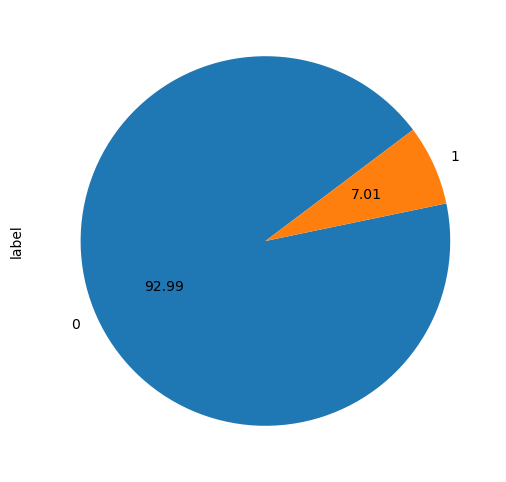

In [303]:
df_train['label'].value_counts().plot.pie(subplots=True,  autopct='%.2f', startangle=37, figsize=(11, 6))

In [304]:
df_test = pd.read_csv('test_tweets.csv')[['tweet']]
df_test

,tweet
0,#studiolife #aislife #requires #passion #dedic...
1,@user #white #supremacists want everyone to s...
2,safe ways to heal your #acne!! #altwaystohe...
3,is the hp and the cursed child book up for res...
4,"3rd #bihday to my amazing, hilarious #nephew..."
...,...
17192,thought factory: left-right polarisation! #tru...
17193,feeling like a mermaid ð #hairflip #neverre...
17194,#hillary #campaigned today in #ohio((omg)) &am...
17195,"happy, at work conference: right mindset leads..."


In [305]:
tqdm.pandas()
df_train['tweet'] = df_train['tweet'].progress_apply(text_preprocess_light)
df_test['tweet'] = df_test['tweet'].progress_apply(text_preprocess_light)

100%|██████████████████████████████████████████████████████████████████████████| 17197/17197 [00:03<00:00, 4964.65it/s]


In [306]:
df_train.head(50)

,tweet,label
0,father dysfunctional selfish drags kids dysfun...,0
1,thanks lyft credit use cause offer wheelchair ...,0
2,bihday majesty,0
3,model love time,0
4,factsguide society motivation,0
5,huge fan fare big talking leave chaos pay disp...,0
6,camping tomorrow danny,0
7,school year year exams think school exams hate...,0
8,love land allin cavs champions cleveland cleve...,0
9,welcome,0


In [307]:
df_test.head(50)

,tweet
0,studiolife aislife requires passion dedication...
1,white supremacists want new birds movie
2,safe ways heal acne altwaystoheal healthy healing
3,cursed child book reservations yes nowhen harr...
4,bihday amazing hilarious nephew eli ahmir uncl...
5,choose momtips
6,inside dies eyes ness smokeyeyes tired lonely ...
7,finished tattoo inked ink loveit thanks aleeee
8,understand dad left young deep inthefeels
9,delicious food lovelife capetown mannaepicure ...


In [295]:
# df_train.to_csv('train_preproc_spel_cor.csv')

In [296]:
# df_test.to_csv('test_preproc_spel_cor.csv')

In [310]:
df_train.to_csv('train_preproc_no_spel_cor.csv')
df_test.to_csv('test_preproc_no_spel_cor.csv')

In [330]:
df_train.insert(1, 'tweet_token', [word_tokenize(tweet) for tweet in df_train['tweet']], allow_duplicates=True)

In [343]:
df_train

,tweet,tweet_token,label
0,father dysfunctional selfish drags kids dysfun...,"[father, dysfunctional, selfish, drags, kids, ...",0
1,thanks lyft credit use cause offer wheelchair ...,"[thanks, lyft, credit, use, cause, offer, whee...",0
2,bihday majesty,"[bihday, majesty]",0
3,model love time,"[model, love, time]",0
4,factsguide society motivation,"[factsguide, society, motivation]",0
...,...,...,...
31957,ate isz youuu,"[ate, isz, youuu]",0
31958,nina turner airwaves trying wrap mantle genuin...,"[nina, turner, airwaves, trying, wrap, mantle,...",0
31959,listening sad songs monday morning otw work sad,"[listening, sad, songs, monday, morning, otw, ...",0
31960,sikh temple vandalised calgary wso condemns act,"[sikh, temple, vandalised, calgary, wso, conde...",1


In [373]:
df_test.insert(1, 'tweet_token', [word_tokenize(tweet) for tweet in df_test['tweet']], allow_duplicates=True)

In [374]:
df_test

,tweet,tweet_token
0,studiolife aislife requires passion dedication willpower newmaterials,"[studiolife, aislife, requires, passion, dedication, willpower, newmaterials]"
1,white supremacists want new birds movie,"[white, supremacists, want, new, birds, movie]"
2,safe ways heal acne altwaystoheal healthy healing,"[safe, ways, heal, acne, altwaystoheal, healthy, healing]"
3,cursed child book reservations yes nowhen harrypotter pottermore favorite,"[cursed, child, book, reservations, yes, nowhen, harrypotter, pottermore, favorite]"
4,bihday amazing hilarious nephew eli ahmir uncle dave loves misses,"[bihday, amazing, hilarious, nephew, eli, ahmir, uncle, dave, loves, misses]"
...,...,...
17192,thought factory left right polarisation trump uselections leadership politics brexit blm,"[thought, factory, left, right, polarisation, trump, uselections, leadership, politics, brexit, blm]"
17193,feeling like mermaid hairflip neverready formal wedding gown dresses mermaid,"[feeling, like, mermaid, hairflip, neverready, formal, wedding, gown, dresses, mermaid]"
17194,hillary campaigned today ohio omg amp used words like assets amp liability clinton say thee word radicalization,"[hillary, campaigned, today, ohio, omg, amp, used, words, like, assets, amp, liability, clinton, say, thee, word, radicalization]"
17195,happy work conference right mindset leads culture development organizations work mindset,"[happy, work, conference, right, mindset, leads, culture, development, organizations, work, mindset]"


In [357]:
stem_tweet_token =[]
for tokens in df_train['tweet_token']:
    stem_token =  [ps().stem(token) for token in tokens]
    stem_tweet_token.append(stem_token)

In [358]:
df_train.insert(2, 'tweet_stemmed', stem_tweet_token, allow_duplicates=True)

In [356]:
# df_train.drop('tweet_stemmed', axis=1, inplace=True)

In [363]:
df_train

,tweet,tweet_token,tweet_stemmed,label
0,father dysfunctional selfish drags kids dysfunction run,"[father, dysfunctional, selfish, drags, kids, dysfunction, run]","[father, dysfunct, selfish, drag, kid, dysfunct, run]",0
1,thanks lyft credit use cause offer wheelchair vans pdx disapointed getthanked,"[thanks, lyft, credit, use, cause, offer, wheelchair, vans, pdx, disapointed, getthanked]","[thank, lyft, credit, use, caus, offer, wheelchair, van, pdx, disapoint, getthank]",0
2,bihday majesty,"[bihday, majesty]","[bihday, majesti]",0
3,model love time,"[model, love, time]","[model, love, time]",0
4,factsguide society motivation,"[factsguide, society, motivation]","[factsguid, societi, motiv]",0
...,...,...,...,...
31957,ate isz youuu,"[ate, isz, youuu]","[ate, isz, youuu]",0
31958,nina turner airwaves trying wrap mantle genuine hero like shirley chisolm shame imwithher,"[nina, turner, airwaves, trying, wrap, mantle, genuine, hero, like, shirley, chisolm, shame, imwithher]","[nina, turner, airwav, tri, wrap, mantl, genuin, hero, like, shirley, chisolm, shame, imwithh]",0
31959,listening sad songs monday morning otw work sad,"[listening, sad, songs, monday, morning, otw, work, sad]","[listen, sad, song, monday, morn, otw, work, sad]",0
31960,sikh temple vandalised calgary wso condemns act,"[sikh, temple, vandalised, calgary, wso, condemns, act]","[sikh, templ, vandalis, calgari, wso, condemn, act]",1


In [375]:
stem_tweet_token =[]
for tokens in df_test['tweet_token']:
    stem_token =  [ps().stem(token) for token in tokens]
    stem_tweet_token.append(stem_token)

In [376]:
df_test.insert(2, 'tweet_stemmed', stem_tweet_token, allow_duplicates=True)

In [377]:
df_test

,tweet,tweet_token,tweet_stemmed
0,studiolife aislife requires passion dedication willpower newmaterials,"[studiolife, aislife, requires, passion, dedication, willpower, newmaterials]","[studiolif, aislif, requir, passion, dedic, willpow, newmateri]"
1,white supremacists want new birds movie,"[white, supremacists, want, new, birds, movie]","[white, supremacist, want, new, bird, movi]"
2,safe ways heal acne altwaystoheal healthy healing,"[safe, ways, heal, acne, altwaystoheal, healthy, healing]","[safe, way, heal, acn, altwaystoh, healthi, heal]"
3,cursed child book reservations yes nowhen harrypotter pottermore favorite,"[cursed, child, book, reservations, yes, nowhen, harrypotter, pottermore, favorite]","[curs, child, book, reserv, ye, nowhen, harrypott, pottermor, favorit]"
4,bihday amazing hilarious nephew eli ahmir uncle dave loves misses,"[bihday, amazing, hilarious, nephew, eli, ahmir, uncle, dave, loves, misses]","[bihday, amaz, hilari, nephew, eli, ahmir, uncl, dave, love, miss]"
...,...,...,...
17192,thought factory left right polarisation trump uselections leadership politics brexit blm,"[thought, factory, left, right, polarisation, trump, uselections, leadership, politics, brexit, blm]","[thought, factori, left, right, polaris, trump, uselect, leadership, polit, brexit, blm]"
17193,feeling like mermaid hairflip neverready formal wedding gown dresses mermaid,"[feeling, like, mermaid, hairflip, neverready, formal, wedding, gown, dresses, mermaid]","[feel, like, mermaid, hairflip, neverreadi, formal, wed, gown, dress, mermaid]"
17194,hillary campaigned today ohio omg amp used words like assets amp liability clinton say thee word radicalization,"[hillary, campaigned, today, ohio, omg, amp, used, words, like, assets, amp, liability, clinton, say, thee, word, radicalization]","[hillari, campaign, today, ohio, omg, amp, use, word, like, asset, amp, liabil, clinton, say, thee, word, radic]"
17195,happy work conference right mindset leads culture development organizations work mindset,"[happy, work, conference, right, mindset, leads, culture, development, organizations, work, mindset]","[happi, work, confer, right, mindset, lead, cultur, develop, organ, work, mindset]"


In [362]:
pd.set_option('display.max_columns', None)  
pd.set_option('display.expand_frame_repr', False)
pd.set_option('max_colwidth', 400)

In [367]:
nltk.download('wordnet')

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\xiaomi\AppData\Roaming\nltk_data...


True

In [369]:
nltk.download('omw-1.4')

[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\xiaomi\AppData\Roaming\nltk_data...


True

In [370]:
lemma_tweet_token =[]
for tokens in df_train['tweet_stemmed']:
    lemma_token =  [lem().lemmatize(token) for token in tokens]
    lemma_tweet_token.append(lemma_token)

In [371]:
df_train.insert(3, 'tweet_lemmatized', lemma_tweet_token, allow_duplicates=True)

In [372]:
df_train

,tweet,tweet_token,tweet_stemmed,tweet_lemmatized,label
0,father dysfunctional selfish drags kids dysfunction run,"[father, dysfunctional, selfish, drags, kids, dysfunction, run]","[father, dysfunct, selfish, drag, kid, dysfunct, run]","[father, dysfunct, selfish, drag, kid, dysfunct, run]",0
1,thanks lyft credit use cause offer wheelchair vans pdx disapointed getthanked,"[thanks, lyft, credit, use, cause, offer, wheelchair, vans, pdx, disapointed, getthanked]","[thank, lyft, credit, use, caus, offer, wheelchair, van, pdx, disapoint, getthank]","[thank, lyft, credit, use, caus, offer, wheelchair, van, pdx, disapoint, getthank]",0
2,bihday majesty,"[bihday, majesty]","[bihday, majesti]","[bihday, majesti]",0
3,model love time,"[model, love, time]","[model, love, time]","[model, love, time]",0
4,factsguide society motivation,"[factsguide, society, motivation]","[factsguid, societi, motiv]","[factsguid, societi, motiv]",0
...,...,...,...,...,...
31957,ate isz youuu,"[ate, isz, youuu]","[ate, isz, youuu]","[ate, isz, youuu]",0
31958,nina turner airwaves trying wrap mantle genuine hero like shirley chisolm shame imwithher,"[nina, turner, airwaves, trying, wrap, mantle, genuine, hero, like, shirley, chisolm, shame, imwithher]","[nina, turner, airwav, tri, wrap, mantl, genuin, hero, like, shirley, chisolm, shame, imwithh]","[nina, turner, airwav, tri, wrap, mantl, genuin, hero, like, shirley, chisolm, shame, imwithh]",0
31959,listening sad songs monday morning otw work sad,"[listening, sad, songs, monday, morning, otw, work, sad]","[listen, sad, song, monday, morn, otw, work, sad]","[listen, sad, song, monday, morn, otw, work, sad]",0
31960,sikh temple vandalised calgary wso condemns act,"[sikh, temple, vandalised, calgary, wso, condemns, act]","[sikh, templ, vandalis, calgari, wso, condemn, act]","[sikh, templ, vandalis, calgari, wso, condemn, act]",1


In [378]:
lemma_tweet_token =[]
for tokens in df_test['tweet_stemmed']:
    lemma_token =  [lem().lemmatize(token) for token in tokens]
    lemma_tweet_token.append(lemma_token)

In [379]:
df_test.insert(3, 'tweet_lemmatized', lemma_tweet_token, allow_duplicates=True)

In [380]:
df_test

,tweet,tweet_token,tweet_stemmed,tweet_lemmatized
0,studiolife aislife requires passion dedication willpower newmaterials,"[studiolife, aislife, requires, passion, dedication, willpower, newmaterials]","[studiolif, aislif, requir, passion, dedic, willpow, newmateri]","[studiolif, aislif, requir, passion, dedic, willpow, newmateri]"
1,white supremacists want new birds movie,"[white, supremacists, want, new, birds, movie]","[white, supremacist, want, new, bird, movi]","[white, supremacist, want, new, bird, movi]"
2,safe ways heal acne altwaystoheal healthy healing,"[safe, ways, heal, acne, altwaystoheal, healthy, healing]","[safe, way, heal, acn, altwaystoh, healthi, heal]","[safe, way, heal, acn, altwaystoh, healthi, heal]"
3,cursed child book reservations yes nowhen harrypotter pottermore favorite,"[cursed, child, book, reservations, yes, nowhen, harrypotter, pottermore, favorite]","[curs, child, book, reserv, ye, nowhen, harrypott, pottermor, favorit]","[cur, child, book, reserv, ye, nowhen, harrypott, pottermor, favorit]"
4,bihday amazing hilarious nephew eli ahmir uncle dave loves misses,"[bihday, amazing, hilarious, nephew, eli, ahmir, uncle, dave, loves, misses]","[bihday, amaz, hilari, nephew, eli, ahmir, uncl, dave, love, miss]","[bihday, amaz, hilari, nephew, eli, ahmir, uncl, dave, love, miss]"
...,...,...,...,...
17192,thought factory left right polarisation trump uselections leadership politics brexit blm,"[thought, factory, left, right, polarisation, trump, uselections, leadership, politics, brexit, blm]","[thought, factori, left, right, polaris, trump, uselect, leadership, polit, brexit, blm]","[thought, factori, left, right, polaris, trump, uselect, leadership, polit, brexit, blm]"
17193,feeling like mermaid hairflip neverready formal wedding gown dresses mermaid,"[feeling, like, mermaid, hairflip, neverready, formal, wedding, gown, dresses, mermaid]","[feel, like, mermaid, hairflip, neverreadi, formal, wed, gown, dress, mermaid]","[feel, like, mermaid, hairflip, neverreadi, formal, wed, gown, dress, mermaid]"
17194,hillary campaigned today ohio omg amp used words like assets amp liability clinton say thee word radicalization,"[hillary, campaigned, today, ohio, omg, amp, used, words, like, assets, amp, liability, clinton, say, thee, word, radicalization]","[hillari, campaign, today, ohio, omg, amp, use, word, like, asset, amp, liabil, clinton, say, thee, word, radic]","[hillari, campaign, today, ohio, omg, amp, use, word, like, asset, amp, liabil, clinton, say, thee, word, radic]"
17195,happy work conference right mindset leads culture development organizations work mindset,"[happy, work, conference, right, mindset, leads, culture, development, organizations, work, mindset]","[happi, work, confer, right, mindset, lead, cultur, develop, organ, work, mindset]","[happi, work, confer, right, mindset, lead, cultur, develop, organ, work, mindset]"


In [381]:
with open('train_preprocess.pickle', 'wb') as f:
    pk.dump(df_train, f, protocol=pk.HIGHEST_PROTOCOL)
with open('test_preprocess.pickle', 'wb') as f:
    pk.dump(df_test, f, protocol=pk.HIGHEST_PROTOCOL)

In [384]:
with open('train_preprocess.pickle', 'rb') as handle:
    train = pk.load(handle)
with open('test_preprocess.pickle', 'rb') as handle:
    test = pk.load(handle)

In [385]:
train

,tweet,tweet_token,tweet_stemmed,tweet_lemmatized,label
0,father dysfunctional selfish drags kids dysfunction run,"[father, dysfunctional, selfish, drags, kids, dysfunction, run]","[father, dysfunct, selfish, drag, kid, dysfunct, run]","[father, dysfunct, selfish, drag, kid, dysfunct, run]",0
1,thanks lyft credit use cause offer wheelchair vans pdx disapointed getthanked,"[thanks, lyft, credit, use, cause, offer, wheelchair, vans, pdx, disapointed, getthanked]","[thank, lyft, credit, use, caus, offer, wheelchair, van, pdx, disapoint, getthank]","[thank, lyft, credit, use, caus, offer, wheelchair, van, pdx, disapoint, getthank]",0
2,bihday majesty,"[bihday, majesty]","[bihday, majesti]","[bihday, majesti]",0
3,model love time,"[model, love, time]","[model, love, time]","[model, love, time]",0
4,factsguide society motivation,"[factsguide, society, motivation]","[factsguid, societi, motiv]","[factsguid, societi, motiv]",0
...,...,...,...,...,...
31957,ate isz youuu,"[ate, isz, youuu]","[ate, isz, youuu]","[ate, isz, youuu]",0
31958,nina turner airwaves trying wrap mantle genuine hero like shirley chisolm shame imwithher,"[nina, turner, airwaves, trying, wrap, mantle, genuine, hero, like, shirley, chisolm, shame, imwithher]","[nina, turner, airwav, tri, wrap, mantl, genuin, hero, like, shirley, chisolm, shame, imwithh]","[nina, turner, airwav, tri, wrap, mantl, genuin, hero, like, shirley, chisolm, shame, imwithh]",0
31959,listening sad songs monday morning otw work sad,"[listening, sad, songs, monday, morning, otw, work, sad]","[listen, sad, song, monday, morn, otw, work, sad]","[listen, sad, song, monday, morn, otw, work, sad]",0
31960,sikh temple vandalised calgary wso condemns act,"[sikh, temple, vandalised, calgary, wso, condemns, act]","[sikh, templ, vandalis, calgari, wso, condemn, act]","[sikh, templ, vandalis, calgari, wso, condemn, act]",1


In [386]:
test

,tweet,tweet_token,tweet_stemmed,tweet_lemmatized
0,studiolife aislife requires passion dedication willpower newmaterials,"[studiolife, aislife, requires, passion, dedication, willpower, newmaterials]","[studiolif, aislif, requir, passion, dedic, willpow, newmateri]","[studiolif, aislif, requir, passion, dedic, willpow, newmateri]"
1,white supremacists want new birds movie,"[white, supremacists, want, new, birds, movie]","[white, supremacist, want, new, bird, movi]","[white, supremacist, want, new, bird, movi]"
2,safe ways heal acne altwaystoheal healthy healing,"[safe, ways, heal, acne, altwaystoheal, healthy, healing]","[safe, way, heal, acn, altwaystoh, healthi, heal]","[safe, way, heal, acn, altwaystoh, healthi, heal]"
3,cursed child book reservations yes nowhen harrypotter pottermore favorite,"[cursed, child, book, reservations, yes, nowhen, harrypotter, pottermore, favorite]","[curs, child, book, reserv, ye, nowhen, harrypott, pottermor, favorit]","[cur, child, book, reserv, ye, nowhen, harrypott, pottermor, favorit]"
4,bihday amazing hilarious nephew eli ahmir uncle dave loves misses,"[bihday, amazing, hilarious, nephew, eli, ahmir, uncle, dave, loves, misses]","[bihday, amaz, hilari, nephew, eli, ahmir, uncl, dave, love, miss]","[bihday, amaz, hilari, nephew, eli, ahmir, uncl, dave, love, miss]"
...,...,...,...,...
17192,thought factory left right polarisation trump uselections leadership politics brexit blm,"[thought, factory, left, right, polarisation, trump, uselections, leadership, politics, brexit, blm]","[thought, factori, left, right, polaris, trump, uselect, leadership, polit, brexit, blm]","[thought, factori, left, right, polaris, trump, uselect, leadership, polit, brexit, blm]"
17193,feeling like mermaid hairflip neverready formal wedding gown dresses mermaid,"[feeling, like, mermaid, hairflip, neverready, formal, wedding, gown, dresses, mermaid]","[feel, like, mermaid, hairflip, neverreadi, formal, wed, gown, dress, mermaid]","[feel, like, mermaid, hairflip, neverreadi, formal, wed, gown, dress, mermaid]"
17194,hillary campaigned today ohio omg amp used words like assets amp liability clinton say thee word radicalization,"[hillary, campaigned, today, ohio, omg, amp, used, words, like, assets, amp, liability, clinton, say, thee, word, radicalization]","[hillari, campaign, today, ohio, omg, amp, use, word, like, asset, amp, liabil, clinton, say, thee, word, radic]","[hillari, campaign, today, ohio, omg, amp, use, word, like, asset, amp, liabil, clinton, say, thee, word, radic]"
17195,happy work conference right mindset leads culture development organizations work mindset,"[happy, work, conference, right, mindset, leads, culture, development, organizations, work, mindset]","[happi, work, confer, right, mindset, lead, cultur, develop, organ, work, mindset]","[happi, work, confer, right, mindset, lead, cultur, develop, organ, work, mindset]"
